In [1]:
# 목표 : 첫 4개 음표를 입력하면 나머지를 연주할 수 있는 모델을 만드는 것이 목표


# 0. 사용할 패키지 불러오기
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

# 데이터셋 생성 함수        
def seq2dataset(seq, window_size):    # 아래에서 지정할 윈도우 크기만큼 자르는 함수
    dataset = []
    for i in range(len(seq)-window_size):    # 만약 seq 30 - 4 : 26 범위이면, 0~25
        subset = seq[i:(i+window_size+1)]    # seq i:~ i+window_size+1 만큼 해서 dataset에 넣어준다.
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

Using TensorFlow backend.


#g4	e8f8 g4	e8f8 g8b8a8b8 c8e8e8f8 e4 c8e8 e4     e8f8 g8a8g8f8  g8c8b8c8  
			
			
#a4	c8b8 a4	g8f8 g8f8e8f8g8a8b8c8a8	c4b8c8    b8c8	b8a8b8c8e8e8f8g8  


#g4e8f8g4 	e8f8g8b8 a8b8c8e8 e4 f8e8	  c4 e8e8   e8f8 g8a8g8f8g8c8b8c8
			
			
#a4	c8b8a4	g8f8g8f8 e8f8g8a8 b4 c8a8 c4 a8c8	b8c8e8c8b8c8a8b8


# https://m.blog.naver.com/PostView.nhn?blogId=ahyoon08&logNo=221008211738&proxyReferer=https:%2F%2Fwww.google.com%2F&view=img_10



음계가 문장보다 더 코드화 하기 쉬움.
시계열 자료임.

c(도), d(레), e(미), f(파), g(솔), a(라), b(시)
4(4분음표), 8(8분음표)

6개의 음표로는 위와 같이 2개의 샘플이 나옴. 
각 샘플은 4개의 입력 데이터와 1개의 라벨값으로 구성되어 있음. 
즉 1~4번째 열은 속성(feature)이고, 5번째 열은 y임.
이렇게 4개씩 구간을 보는 것을 '윈도우 크기 4'

문자와 숫자로 된 음표(코드)로는 모델 입출력으로 사용할 수 없다.
아래 사전에서,
-> 첫번째 사전 : 숫자
-> 두번째 사전 : 코드

In [2]:
# 1. 데이터 준비하기. 나온 것들 하나씩 Unique 하게 나열.
# 코드 사전 정의
# 코드를 숫자로
code2idx = {'a4':0, 'a8':1, 'b4':2, 'b8':3, 'c4':4, 'c8':5, 
            'e4':6, 'e8':7, 'f8':8, 'g4':9, 'g8':10}




# 숫자를 코드로
idx2code = {0:'a4', 1:'a8', 2:'b4', 3:'b8', 4:'c4', 5:'c8', 
            6:'e4', 7:'e8', 8:'f8', 9:'g4', 10:'g8'}

# 시퀀스 데이터 정의

seq = ['g4','e8','f8','g4','e8','f8','g8','b8','a8','b8','c8','e8','e8','f8','e4','c8','e8','e4','e8','f8','g8','a8','g8','f8','g8','c8','b8','c8',
'a4','c8','b8','a4','g8','f8','g8','f8','e8','f8','g8','a8','b8','c8','a8','c4','b8','c8','b8','c8','b8','a8','b8','c8','e8','e8','f8','g8',
'g4','e8','f8','g4','e8','f8','g8','b8','a8','b8','c8','e8','e4','f8','e8','c4','e8','e8','e8','f8','g8','a8','g8','f8','g8','c8','b8','c8',
'a4','c8','b8','a4','g8','f8','g8','f8','e8','f8','g8','a8','b4','c8','a8','c4','a8','c8','b8','c8','e8','c8','b8','c8','a8','b8']    # 악보 전체 입력.

In [3]:
# 2. 데이터셋 생성하기     seq2dataset() 함수를 하여 dataset를 생성. 데이터셋은 앞서 정의한 사전에 따라 숫자로 변환되어 생성.
dataset = seq2dataset(seq, window_size = 4) # 윈도우 사이즈 4 + 타겟 1 이므로 5임.

print(dataset.shape)
print(dataset)


(106, 5)
[[ 9  7  8  9  7]
 [ 7  8  9  7  8]
 [ 8  9  7  8 10]
 [ 9  7  8 10  3]
 [ 7  8 10  3  1]
 [ 8 10  3  1  3]
 [10  3  1  3  5]
 [ 3  1  3  5  7]
 [ 1  3  5  7  7]
 [ 3  5  7  7  8]
 [ 5  7  7  8  6]
 [ 7  7  8  6  5]
 [ 7  8  6  5  7]
 [ 8  6  5  7  6]
 [ 6  5  7  6  7]
 [ 5  7  6  7  8]
 [ 7  6  7  8 10]
 [ 6  7  8 10  1]
 [ 7  8 10  1 10]
 [ 8 10  1 10  8]
 [10  1 10  8 10]
 [ 1 10  8 10  5]
 [10  8 10  5  3]
 [ 8 10  5  3  5]
 [10  5  3  5  0]
 [ 5  3  5  0  5]
 [ 3  5  0  5  3]
 [ 5  0  5  3  0]
 [ 0  5  3  0 10]
 [ 5  3  0 10  8]
 [ 3  0 10  8 10]
 [ 0 10  8 10  8]
 [10  8 10  8  7]
 [ 8 10  8  7  8]
 [10  8  7  8 10]
 [ 8  7  8 10  1]
 [ 7  8 10  1  3]
 [ 8 10  1  3  5]
 [10  1  3  5  1]
 [ 1  3  5  1  4]
 [ 3  5  1  4  3]
 [ 5  1  4  3  5]
 [ 1  4  3  5  3]
 [ 4  3  5  3  5]
 [ 3  5  3  5  3]
 [ 5  3  5  3  1]
 [ 3  5  3  1  3]
 [ 5  3  1  3  5]
 [ 3  1  3  5  7]
 [ 1  3  5  7  7]
 [ 3  5  7  7  8]
 [ 5  7  7  8 10]
 [ 7  7  8 10  9]
 [ 7  8 10  9  7]
 [ 8 10  9  7  8]
 

예측 과정
1) 한 스텝 단위 예측 
2) 곡 전체 예측입니다.

1) 한 스텝 예측
한 스텝 예측이란 실제 음표 4개를 입력하여 다음 음표 1개를 예측하는 것을 반복하는 것. 

2) 곡 전체 예측
입력된 초기 4개 음표만을 입력으로 곡 전체를 예측. 만약 중간에 틀린 부분이 생긴다면, 이후 음정, 박자는 모두 이상하게 될 가능성 존재.

-> 처음 윈도우사이즈(4개)만 사용해서 다음 5번째 음정을 예측, 그리고 슬라이딩 윈도우 사용해서 결국엔 예측값들만으로 다음 음정을 예측하는 방법.



In [4]:
# 1~4번째 음표를 데이터로 5번째 음표를 라벨값으로 학습. 끝까지 이렇게 반복.


# 입력(X)과 출력(Y) 변수로 분리하기
mlp_x_train = dataset[:,0:4]   #  학습필요.  행 : 전체, 로우 : 0,1,2,3 가져옴.
mlp_y_train = dataset[:,4]     #  학습필요   행 : 전체, 로우 : 4번째 만 가져옴.


In [5]:
print(mlp_x_train)

[[ 9  7  8  9]
 [ 7  8  9  7]
 [ 8  9  7  8]
 [ 9  7  8 10]
 [ 7  8 10  3]
 [ 8 10  3  1]
 [10  3  1  3]
 [ 3  1  3  5]
 [ 1  3  5  7]
 [ 3  5  7  7]
 [ 5  7  7  8]
 [ 7  7  8  6]
 [ 7  8  6  5]
 [ 8  6  5  7]
 [ 6  5  7  6]
 [ 5  7  6  7]
 [ 7  6  7  8]
 [ 6  7  8 10]
 [ 7  8 10  1]
 [ 8 10  1 10]
 [10  1 10  8]
 [ 1 10  8 10]
 [10  8 10  5]
 [ 8 10  5  3]
 [10  5  3  5]
 [ 5  3  5  0]
 [ 3  5  0  5]
 [ 5  0  5  3]
 [ 0  5  3  0]
 [ 5  3  0 10]
 [ 3  0 10  8]
 [ 0 10  8 10]
 [10  8 10  8]
 [ 8 10  8  7]
 [10  8  7  8]
 [ 8  7  8 10]
 [ 7  8 10  1]
 [ 8 10  1  3]
 [10  1  3  5]
 [ 1  3  5  1]
 [ 3  5  1  4]
 [ 5  1  4  3]
 [ 1  4  3  5]
 [ 4  3  5  3]
 [ 3  5  3  5]
 [ 5  3  5  3]
 [ 3  5  3  1]
 [ 5  3  1  3]
 [ 3  1  3  5]
 [ 1  3  5  7]
 [ 3  5  7  7]
 [ 5  7  7  8]
 [ 7  7  8 10]
 [ 7  8 10  9]
 [ 8 10  9  7]
 [10  9  7  8]
 [ 9  7  8  9]
 [ 7  8  9  7]
 [ 8  9  7  8]
 [ 9  7  8 10]
 [ 7  8 10  3]
 [ 8 10  3  1]
 [10  3  1  3]
 [ 3  1  3  5]
 [ 1  3  5  7]
 [ 3  5  7  6]
 [ 5  7  6

In [6]:

max_idx_value = 10   # 총 11개 데이터에서 나눠줘야 하기 때문에 0~10. 최대값인 10으로 나눠졌다.
# # 1. 데이터 준비하기. 나온 것들 하나씩 Unique 하게 나열.
# 코드 사전 정의
# 코드를 숫자로  여기에서 정의된 것들이 0~ 10까지 있다.


# 입력값 정규화 시키기
mlp_x_train = mlp_x_train / float(max_idx_value)   # 10.0

# y값에 대한 라벨값에 대한 one-hot 인코딩 수행 이유 : 구분되야 하는 값이 3개가 넘어가므로 원핫인코딩 해줌. 2개를 안쓰므로 12개로 해줌.
mlp_y_train = np_utils.to_categorical(mlp_y_train)

one_hot_vec_size = mlp_y_train.shape[1]  # 이 부분은 12라고 정수로 써줘도 무관.

print("one hot encoding vector size is ", one_hot_vec_size)

one hot encoding vector size is  11


In [7]:
print(float(max_idx_value))

10.0


In [8]:
print(mlp_x_train)

[[0.9 0.7 0.8 0.9]
 [0.7 0.8 0.9 0.7]
 [0.8 0.9 0.7 0.8]
 [0.9 0.7 0.8 1. ]
 [0.7 0.8 1.  0.3]
 [0.8 1.  0.3 0.1]
 [1.  0.3 0.1 0.3]
 [0.3 0.1 0.3 0.5]
 [0.1 0.3 0.5 0.7]
 [0.3 0.5 0.7 0.7]
 [0.5 0.7 0.7 0.8]
 [0.7 0.7 0.8 0.6]
 [0.7 0.8 0.6 0.5]
 [0.8 0.6 0.5 0.7]
 [0.6 0.5 0.7 0.6]
 [0.5 0.7 0.6 0.7]
 [0.7 0.6 0.7 0.8]
 [0.6 0.7 0.8 1. ]
 [0.7 0.8 1.  0.1]
 [0.8 1.  0.1 1. ]
 [1.  0.1 1.  0.8]
 [0.1 1.  0.8 1. ]
 [1.  0.8 1.  0.5]
 [0.8 1.  0.5 0.3]
 [1.  0.5 0.3 0.5]
 [0.5 0.3 0.5 0. ]
 [0.3 0.5 0.  0.5]
 [0.5 0.  0.5 0.3]
 [0.  0.5 0.3 0. ]
 [0.5 0.3 0.  1. ]
 [0.3 0.  1.  0.8]
 [0.  1.  0.8 1. ]
 [1.  0.8 1.  0.8]
 [0.8 1.  0.8 0.7]
 [1.  0.8 0.7 0.8]
 [0.8 0.7 0.8 1. ]
 [0.7 0.8 1.  0.1]
 [0.8 1.  0.1 0.3]
 [1.  0.1 0.3 0.5]
 [0.1 0.3 0.5 0.1]
 [0.3 0.5 0.1 0.4]
 [0.5 0.1 0.4 0.3]
 [0.1 0.4 0.3 0.5]
 [0.4 0.3 0.5 0.3]
 [0.3 0.5 0.3 0.5]
 [0.5 0.3 0.5 0.3]
 [0.3 0.5 0.3 0.1]
 [0.5 0.3 0.1 0.3]
 [0.3 0.1 0.3 0.5]
 [0.1 0.3 0.5 0.7]
 [0.3 0.5 0.7 0.7]
 [0.5 0.7 0.7 0.8]
 [0.7 0.7 0.

# 다층 퍼셉트론 모델

#입력 속성이 4개(윈도우사이즈) 이고 출력이 11개(one_hot_vec_size=11)

In [9]:
# 3. 모델 구성하기
model = Sequential()
model.add(Dense(256, input_dim=4, activation='relu'))  # 인풋, 윈도우 사이즈만큼 4개로)
dropout = 0.3
model.add(Dense(128, activation='relu'))
dropout = 0.3
model.add(Dense(one_hot_vec_size, activation='softmax'))

In [10]:
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#history = LossHistory() # 손실 이력 객체 생성  #위에 # 손실 이력 클래스 정의 사용.
#history.init()

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1419      
Total params: 35,595
Trainable params: 35,595
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.weights

#shape(4,256) -> 한개에서 768개.  X -> 히든레이어로
#Shape (256, ) -> 바이어스
#shape(256, 128) -> 레이어에서 레이어로
#Shape (128, ) -> 바이어스
#shape (128, 11) -> 히든레이어에서 y로(출력 레이어)
#shape(11, ) -> 히든에서 y로 넘어올 때 보이는 바이어스

[<tf.Variable 'dense_1/kernel:0' shape=(4, 256) dtype=float32, numpy=
 array([[-0.10385889,  0.10828912,  0.1336573 , ...,  0.09360293,
          0.14877066, -0.12067041],
        [-0.06138494,  0.05613537, -0.03769834, ..., -0.1036143 ,
         -0.05425702,  0.0361007 ],
        [ 0.08481349, -0.05134659,  0.01865812, ..., -0.06340154,
         -0.07774098,  0.00072932],
        [-0.1293998 , -0.10858741,  0.00364669, ..., -0.12063919,
         -0.00864758,  0.12385812]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [13]:
# 5. 모델 학습시키기
history = model.fit(mlp_x_train, mlp_y_train, epochs=20, batch_size=4, verbose=1, validation_split=0.2)

Train on 84 samples, validate on 22 samples
Epoch 1/20
84/84 [==============================] - 0s 2ms/step - loss: 2.3563 - accuracy: 0.1548 - val_loss: 2.2565 - val_accuracy: 0.1818
Epoch 2/20
84/84 [==============================] - 0s 434us/step - loss: 2.1971 - accuracy: 0.2857 - val_loss: 2.1665 - val_accuracy: 0.2727
Epoch 3/20
84/84 [==============================] - 0s 447us/step - loss: 2.1130 - accuracy: 0.2619 - val_loss: 2.1318 - val_accuracy: 0.2727
Epoch 4/20
84/84 [==============================] - 0s 412us/step - loss: 2.0584 - accuracy: 0.3214 - val_loss: 2.1016 - val_accuracy: 0.2727
Epoch 5/20
84/84 [==============================] - 0s 479us/step - loss: 2.0185 - accuracy: 0.2619 - val_loss: 2.0987 - val_accuracy: 0.2727
Epoch 6/20
84/84 [==============================] - 0s 414us/step - loss: 1.9960 - accuracy: 0.2619 - val_loss: 2.1222 - val_accuracy: 0.2273
Epoch 7/20
84/84 [==============================] - 0s 424us/step - loss: 1.9434 - accuracy: 0.3214 - val_

In [14]:
# 6. 모델 평가하기
scores = model.evaluate(mlp_x_train, mlp_y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

106/106 [==============================] - 0s 60us/step
accuracy: 43.40%


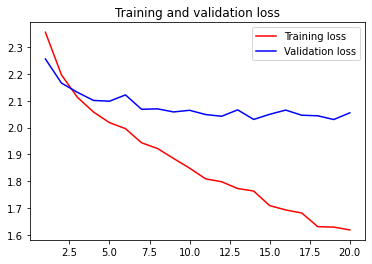

In [15]:
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


# loss 그래프를 살펴보면 Training loss는 점점 하락.
# 하지만 Vaildation loss는 높으므로 좋은 모델이 아님, epochs 향상 필요.


In [16]:
# 7. 모델 사용하기

pred_count = 106 # 최대 예측 개수 정의

In [17]:
# 한 스텝 예측

one_step_seq_out = ['g4','e8','f8','g4']
pred_out = model.predict(mlp_x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # 인덱스의 최대값을 뽑아옴. 
    one_step_seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", one_step_seq_out)


one step prediction :  ['g4', 'e8', 'f8', 'g4', 'e8', 'e8', 'e8', 'e8', 'g8', 'c8', 'c8', 'e8', 'e8', 'e8', 'f8', 'e8', 'b8', 'e8', 'e8', 'f8', 'e8', 'e8', 'g8', 'f8', 'g8', 'f8', 'g8', 'c8', 'c8', 'c8', 'b8', 'a4', 'b8', 'f8', 'g8', 'f8', 'e8', 'f8', 'e8', 'e8', 'g8', 'c8', 'a4', 'g8', 'b8', 'a4', 'f8', 'c8', 'f8', 'c8', 'c8', 'c8', 'e8', 'e8', 'e8', 'f8', 'e8', 'e8', 'f8', 'e8', 'e8', 'e8', 'e8', 'e8', 'g8', 'c8', 'c8', 'e8', 'e8', 'e8', 'f8', 'e8', 'b8', 'e8', 'e8', 'f8', 'e8', 'e8', 'g8', 'f8', 'g8', 'f8', 'g8', 'c8', 'c8', 'c8', 'b8', 'a4', 'b8', 'f8', 'g8', 'f8', 'e8', 'f8', 'e8', 'e8', 'g8', 'c8', 'a4', 'g8', 'b8', 'c8', 'f8', 'g8', 'f8', 'e8', 'e8', 'b8', 'c8', 'c8']


In [18]:
print(idx)

5


In [19]:
print(pred_out[i])

[0.11963883 0.09281344 0.00182104 0.14738292 0.02792251 0.38800636
 0.00790973 0.04883266 0.01092283 0.01147489 0.14327478]


In [20]:
# 곡 전체 예측

seq_in = ['g4','e8','f8','g4']
full_seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)  # [0.9 0.7 0.8 0.9]
    sample_in = np.reshape(sample_in, (1, 4)) # [[0.9 0.7 0.8 0.9]], batch_size, feature
    pred_out = model.predict(sample_in) # [[0.9 0.7 0.8 0.9]] 이것만 갖고 예측하도록 만든 곳......
    idx = np.argmax(pred_out)  # 10
    full_seq_out.append(idx2code[idx]) 
    seq_in.append(idx / float(max_idx_value))  # 10/10.0
    seq_in.pop(0)
   
print("full song prediction : ", full_seq_out)

full song prediction :  ['g4', 'e8', 'f8', 'g4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']


In [21]:
print(full_seq_out)

['g4', 'e8', 'f8', 'g4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']


In [22]:
print(idx)

7


**Vanilla RNN**

In [23]:
from keras.layers import SimpleRNN, Activation, LSTM, Flatten, GRU

In [24]:
srnn_x_train = dataset[:,0:4]   #  학습필요.  행 : 전체, 로우 : 0,1,2,3 가져옴.
srnn_y_train = dataset[:,4] 



# 입력값 정규화 시키기
srnn_x_train = srnn_x_train / float(max_idx_value)   # 10.0



# 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환
srnn_x_train = np.reshape(srnn_x_train, (106, 4, 1)) # 정말 중요 !!!!
# 정말 중요 !!!!

# y값에 대한 라벨값에 대한 one-hot 인코딩 수행 이유 : 구분되야 하는 값이 3개가 넘어가므로 원핫인코딩 해줌. 2개를 안쓰므로 12개로 해줌.
srnn_y_train = np_utils.to_categorical(srnn_y_train)

one_hot_vec_size = srnn_y_train.shape[1]  # 이 부분은 12라고 정수로 써줘도 무관.

print("one hot encoding vector size is ", one_hot_vec_size)

one hot encoding vector size is  11


In [25]:
model = Sequential()
model.add(SimpleRNN(256, input_shape = (4, 1)))
Dropout = 0.3
#model.add(SimpleRNN(128))
model.add(Dense(128, activation='relu'))
Dropout = 0.3
#model.add(Flatten())
#model.add(Flatten())
model.add(Dense(one_hot_vec_size, activation='softmax'))

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 256)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 11)                1419      
Total params: 100,363
Trainable params: 100,363
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.weights

#shape(1,256) -> 한개에서 768개.  X -> 히든레이어로
#shape(256, 256) -> 레이어에서 레이어로
#Shape (256, ) -> 바이어스
#shape(256, 128) -> 레이어에서 레이어로
#Shape (128, ) -> 바이어스
#shape (128, 11) -> 히든레이어에서 y로(출력 레이어)
#shape(11, ) -> 히든에서 y로 넘어올 때 보이는 바이어스

[<tf.Variable 'simple_rnn_1/kernel:0' shape=(1, 256) dtype=float32, numpy=
 array([[ 0.06210589,  0.00125262, -0.12381008,  0.03672817,  0.0069042 ,
         -0.01996759, -0.02706859, -0.10772955, -0.09948017, -0.11549333,
         -0.01600592,  0.01279753,  0.09837188,  0.11697493, -0.00057343,
         -0.11472009, -0.02909149, -0.03065481,  0.13671212,  0.14357458,
         -0.00746346,  0.07902469,  0.03318854, -0.07542232,  0.00610994,
         -0.07006796, -0.0470762 ,  0.11211435, -0.00040993,  0.00651182,
         -0.00994895,  0.0264958 ,  0.08332762,  0.01025364,  0.04929732,
         -0.13862355,  0.07254668,  0.12253888,  0.14343245, -0.04089402,
          0.08652581,  0.01854178, -0.06649029, -0.05897418,  0.11849611,
         -0.06403693,  0.08671823,  0.11704554,  0.03896317,  0.13329928,
         -0.02817643, -0.131205  ,  0.14830323,  0.10093777,  0.15016712,
          0.05305648, -0.0509743 , -0.11242145,  0.09321919,  0.04121985,
          0.01912925, -0.07333653,  0

In [29]:
history = model.fit(srnn_x_train, srnn_y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)

Train on 84 samples, validate on 22 samples
Epoch 1/20
84/84 [==============================] - 0s 3ms/step - loss: 2.3378 - accuracy: 0.1190 - val_loss: 2.1557 - val_accuracy: 0.3636
Epoch 2/20
84/84 [==============================] - 0s 570us/step - loss: 2.1600 - accuracy: 0.2262 - val_loss: 2.1180 - val_accuracy: 0.2273
Epoch 3/20
84/84 [==============================] - 0s 537us/step - loss: 2.0767 - accuracy: 0.2262 - val_loss: 2.1556 - val_accuracy: 0.1364
Epoch 4/20
84/84 [==============================] - 0s 532us/step - loss: 2.0498 - accuracy: 0.1905 - val_loss: 2.1276 - val_accuracy: 0.0909
Epoch 5/20
84/84 [==============================] - 0s 545us/step - loss: 1.9958 - accuracy: 0.2262 - val_loss: 2.1513 - val_accuracy: 0.2273
Epoch 6/20
84/84 [==============================] - 0s 519us/step - loss: 1.9514 - accuracy: 0.3333 - val_loss: 2.1110 - val_accuracy: 0.1364
Epoch 7/20
84/84 [==============================] - 0s 511us/step - loss: 1.9270 - accuracy: 0.2738 - val_

In [30]:
scores = model.evaluate(srnn_x_train, srnn_y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

106/106 [==============================] - 0s 79us/step
accuracy: 35.85%


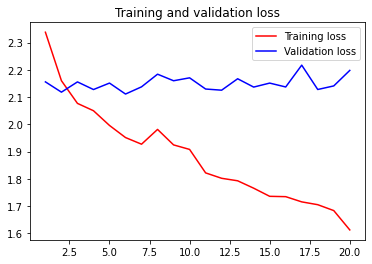

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


# loss 그래프를 살펴보면 Training loss는 점점 하락.
# 하지만 Vaildation loss는 높아지는 것을 봤을 때 과적합인것을 의심 가능. 그러므로  epochs 증가 학습 더 필요.

In [32]:
pred_count = 106 # 최대 예측 개수 정의

In [33]:
# 한 스텝 예측

one_step_seq_out = ['g4','e8','f8','g4']
pred_out = model.predict(srnn_x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # 인덱스의 최대값을 뽑아옴. 
    one_step_seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", one_step_seq_out)


one step prediction :  ['g4', 'e8', 'f8', 'g4', 'g8', 'g8', 'g8', 'g8', 'g8', 'c8', 'c8', 'e8', 'e8', 'e8', 'f8', 'g8', 'g8', 'e8', 'e8', 'f8', 'g8', 'e8', 'g8', 'f8', 'g8', 'c8', 'g8', 'f8', 'g8', 'g8', 'b8', 'g8', 'g8', 'e8', 'g8', 'c8', 'g8', 'g8', 'g8', 'g8', 'g8', 'c8', 'g8', 'b8', 'b8', 'g8', 'b8', 'e8', 'b8', 'e8', 'b8', 'c8', 'e8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'c8', 'c8', 'e8', 'e8', 'e8', 'f8', 'g8', 'f8', 'e8', 'g8', 'f8', 'e8', 'g8', 'g8', 'f8', 'g8', 'c8', 'g8', 'f8', 'g8', 'g8', 'b8', 'g8', 'g8', 'e8', 'g8', 'c8', 'g8', 'g8', 'g8', 'g8', 'g8', 'c8', 'g8', 'e8', 'b8', 'g8', 'b8', 'g8', 'f8', 'e8', 'e8', 'f8', 'e8', 'e8']


In [34]:
# 곡 전체 예측

seq_in = ['g4','e8','f8','g4']
full_seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)  # [0.9 0.7 0.8 0.9]
    sample_in = np.reshape(sample_in, (1, 4, 1)) # [[0.9 0.7 0.8 0.9]], batch_size, feature, attribute
    pred_out = model.predict(sample_in) # [[0.9 0.7 0.8 0.9]] 이것만 갖고 예측하도록 만든 곳......
    idx = np.argmax(pred_out)  # 10
    full_seq_out.append(idx2code[idx]) 
    seq_in.append(idx / float(max_idx_value))  # 10/10.0
    seq_in.pop(0)
   
print("full song prediction : ", full_seq_out)

full song prediction :  ['g4', 'e8', 'f8', 'g4', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8', 'g8']


Stateful LSTM 
# 상태유지 모드에서는 현재 샘플의 학습 상태가 다음 샘플의 초기 상태로 전달된다.

In [35]:
slstm_x_train = dataset[:,0:4]   #  학습필요.  행 : 전체, 로우 : 0,1,2,3 가져옴.
slstm_y_train = dataset[:,4] 


# 입력값 정규화 시키기
slstm_x_train = slstm_x_train / float(max_idx_value)   # 10.0



# 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환
slstm_x_train = np.reshape(slstm_x_train, (106, 4, 1)) # 정말 중요 !!!!
# 정말 중요 !!!!

# y값에 대한 라벨값에 대한 one-hot 인코딩 수행 이유 : 구분되야 하는 값이 3개가 넘어가므로 원핫인코딩 해줌. 2개를 안쓰므로 12개로 해줌.
slstm_y_train = np_utils.to_categorical(slstm_y_train)

one_hot_vec_size = slstm_y_train.shape[1]  # 이 부분은 12라고 정수로 써줘도 무관.

print("one hot encoding vector size is ", one_hot_vec_size)

one hot encoding vector size is  11


In [36]:
model = Sequential()
model.add(LSTM(256, batch_input_shape = (1, 4, 1), stateful=True, return_sequences=True))   # 상태유지 LSTM 모델을 생성하기 위해서는 LSTM 레이어 생성 시, stateful=True로 설정
 # 상태유지 모드에서는 입력형태를 batch_input_shape = (배치사이즈, 타임스텝, 속성)으로 설정
dropout=0.3
model.add(LSTM(128, return_sequences=False))
dropout=0.3
model.add(Dense(one_hot_vec_size, activation='softmax'))

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
model.weights

#shape(1,1024) -> 한개에서 768개.  X -> 히든레이어로
#shape(256, 1024) -> 레이어에서 레이어로
#Shape (1024, ) -> 바이어스
#shape(256, 512) -> 레이어에서 레이어로
#shape(128, 512) -> 레이어에서 레이어로 (순환레이어)
#Shape (512, ) -> 바이어스
#shape (128, 11) -> 히든레이어에서 y로(출력 레이어)
#shape(11, ) -> 히든에서 y로 넘어올 때 보이는 바이어스

[<tf.Variable 'lstm_1/kernel:0' shape=(1, 1024) dtype=float32, numpy=
 array([[-0.00072067,  0.06937678, -0.06063251, ...,  0.04058098,
         -0.06868935, -0.00119077]], dtype=float32)>,
 <tf.Variable 'lstm_1/recurrent_kernel:0' shape=(256, 1024) dtype=float32, numpy=
 array([[-0.03766399, -0.01335462, -0.01576716, ...,  0.02129538,
          0.01635417,  0.01658975],
        [-0.0277096 ,  0.016492  ,  0.01976645, ..., -0.00834349,
          0.00172124,  0.01442848],
        [-0.02932655,  0.06143856,  0.01811641, ...,  0.00196634,
         -0.01864892, -0.01700939],
        ...,
        [ 0.0476618 , -0.06519192, -0.03247499, ...,  0.01786317,
          0.0235286 , -0.02106552],
        [-0.04049762, -0.0169132 ,  0.04229394, ...,  0.00625562,
          0.02278994, -0.02076214],
        [ 0.02384838,  0.01727076,  0.02250842, ...,  0.03847176,
          0.03300765,  0.05417418]], dtype=float32)>,
 <tf.Variable 'lstm_1/bias:0' shape=(1024,) dtype=float32, numpy=array([0., 0., 0., .

In [39]:
#  현재 샘플과 다음 샘플 간의 순차적인 관계가 없을 경우에는 상태가 유지되지 않고 초기화가 되어야 함. 예를들어......
 # 1) 마지막 샘플 학습이 마치고, 새로운 에포크 수행 시에는 새로운 샘플 학습을 해야하므로 상태 초기화 필요 (현재 모델에 해당)
 # 2) 한 에포크 안에 여러 시퀀스 데이터 세트가 있을 경우, 새로운 시퀀스 데이터 세트를 학습 전에 상태 초기화 필요
 
num_epochs = 2

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    #model.fit(slstm_x_train, slstm_y_train, epochs=1, batch_size=1, verbose=2, shuffle=False)
    history = model.fit(slstm_x_train, slstm_y_train, epochs=1, batch_size=1, verbose=1, shuffle=False, validation_split=0.2)
    model.reset_states()

epochs : 0
Train on 84 samples, validate on 22 samples
Epoch 1/1
84/84 [==============================] - 1s 17ms/step - loss: 2.3335 - accuracy: 0.0833 - val_loss: 2.2355 - val_accuracy: 0.0909
epochs : 1
Train on 84 samples, validate on 22 samples
Epoch 1/1
84/84 [==============================] - 1s 11ms/step - loss: 2.1793 - accuracy: 0.1190 - val_loss: 2.2383 - val_accuracy: 0.0909


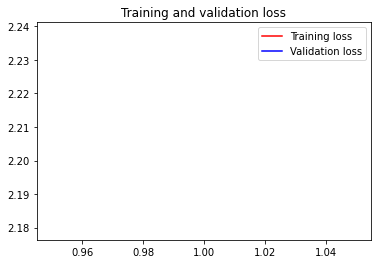

In [40]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [41]:
scores = model.evaluate(slstm_x_train, slstm_y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

106/106 [==============================] - 0s 1ms/step
accuracy: 16.04%


In [42]:
pred_count = 106 # 최대 예측 개수 정의

In [43]:
one_step_seq_out = ['g4','e8','f8','g4']
pred_out = model.predict(slstm_x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # 인덱스의 최대값을 뽑아옴. 
    one_step_seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

model.reset_states()

print("one step prediction : ", one_step_seq_out)



one step prediction :  ['g4', 'e8', 'f8', 'g4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']


In [44]:
# 곡 전체 예측

seq_in = ['g4','e8','f8','g4']
full_seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)  # [0.9 0.7 0.8 0.9]
    sample_in = np.reshape(sample_in, (1, 4, 1)) # [[0.9 0.7 0.8 0.9]], batch_size, feature, attribute
    pred_out = model.predict(sample_in) # [[0.9 0.7 0.8 0.9]] 이것만 갖고 예측하도록 만든 곳......
    idx = np.argmax(pred_out)  # 10
    full_seq_out.append(idx2code[idx]) 
    seq_in.append(idx / float(max_idx_value))  # 10/10.0
    seq_in.pop(0)
   

model.reset_states()

print("full song prediction : ", full_seq_out)


full song prediction :  ['g4', 'e8', 'f8', 'g4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']


# GRU 구현

GRU 이해
https://it-ist.tistory.com/27

In [45]:
gru_x_train = dataset[:,0:4]   #  학습필요.  행 : 전체, 로우 : 0,1,2,3 가져옴.
gru_y_train = dataset[:,4] 


# 입력값 정규화 시키기
gru_x_train = gru_x_train / float(max_idx_value)   # 10.0



# 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환
gru_x_train = np.reshape(gru_x_train, (106, 4, 1)) # 정말 중요 !!!!
# 정말 중요 !!!!

# y값에 대한 라벨값에 대한 one-hot 인코딩 수행 이유 : 구분되야 하는 값이 3개가 넘어가므로 원핫인코딩 해줌. 2개를 안쓰므로 12개로 해줌.
gru_y_train = np_utils.to_categorical(gru_y_train)

one_hot_vec_size = gru_y_train.shape[1]  # 이 부분은 12라고 정수로 써줘도 무관.

print("one hot encoding vector size is ", one_hot_vec_size)

one hot encoding vector size is  11


In [46]:
model = Sequential()
model.add(GRU(256,input_shape = (4, 1))) #GRU를 호출
Dropout = 0.3
model.add(Dense(128, activation='relu'))
Dropout = 0.3
model.add(Dense(one_hot_vec_size, activation='softmax'))

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 256)               198144    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 11)                1419      
Total params: 232,459
Trainable params: 232,459
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.weights

#shape(1,768) -> 한개에서 768개.  X -> 히든레이어로
#shape(256, 768) -> 레이어에서 레이어로
#Shape (768, ) -> 바이어스
#shape(256, 128) -> 레이어에서 레이어로
#Shape (128, ) -> 바이어스
#shape (128, 11) -> 히든레이어에서 y로(출력 레이어)
#shape(11, ) -> 히든에서 y로 넘어올 때 보이는 바이어스

[<tf.Variable 'gru_1/kernel:0' shape=(1, 768) dtype=float32, numpy=
 array([[ 0.04921014,  0.07220829,  0.06886447, -0.05190243,  0.06971536,
         -0.01800396,  0.03188157,  0.08645747, -0.06336058,  0.07779887,
         -0.08086405,  0.05243935, -0.07364402, -0.01243888,  0.0159766 ,
          0.01309318,  0.02931271,  0.02859196,  0.05644164, -0.02093201,
         -0.0715626 , -0.07492268,  0.02453733, -0.01932675, -0.08196156,
          0.03755195, -0.03037125, -0.0362368 , -0.02586801,  0.06136083,
         -0.05181141,  0.07805369, -0.08147365,  0.07141925, -0.01210925,
          0.08480457, -0.03757534,  0.06876255,  0.05324978, -0.02472213,
         -0.02049317, -0.05413815, -0.0017724 , -0.04239201,  0.0086778 ,
         -0.02512827,  0.02317209, -0.05649667, -0.02691038,  0.04285672,
         -0.04826418,  0.08333457,  0.078462  , -0.05748953, -0.021795  ,
         -0.06646264, -0.05035709, -0.05375015, -0.06555675, -0.00274084,
          0.01198409,  0.06662489,  0.017760

In [50]:
history = model.fit(gru_x_train, gru_y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)

Train on 84 samples, validate on 22 samples
Epoch 1/20
84/84 [==============================] - 1s 7ms/step - loss: 2.3727 - accuracy: 0.0952 - val_loss: 2.3286 - val_accuracy: 0.2727
Epoch 2/20
84/84 [==============================] - 0s 2ms/step - loss: 2.2930 - accuracy: 0.2143 - val_loss: 2.2292 - val_accuracy: 0.2273
Epoch 3/20
84/84 [==============================] - 0s 2ms/step - loss: 2.1828 - accuracy: 0.1310 - val_loss: 2.1776 - val_accuracy: 0.1818
Epoch 4/20
84/84 [==============================] - 0s 2ms/step - loss: 2.1424 - accuracy: 0.1429 - val_loss: 2.2007 - val_accuracy: 0.1364
Epoch 5/20
84/84 [==============================] - 0s 2ms/step - loss: 2.1272 - accuracy: 0.1786 - val_loss: 2.1839 - val_accuracy: 0.2273
Epoch 6/20
84/84 [==============================] - 0s 2ms/step - loss: 2.1321 - accuracy: 0.2024 - val_loss: 2.2145 - val_accuracy: 0.0909
Epoch 7/20
84/84 [==============================] - 0s 2ms/step - loss: 2.1224 - accuracy: 0.1786 - val_loss: 2.1805

In [51]:
scores = model.evaluate(gru_x_train, gru_y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

106/106 [==============================] - 0s 175us/step
accuracy: 28.30%


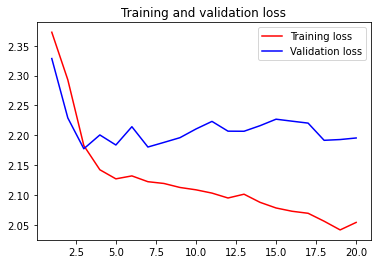

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


# loss 그래프를 살펴보면 Training loss는 점점 하락.
# 하지만 Vaildation loss는 높아지는 것을 봤을 때 과적합인것을 의심 가능.

In [53]:
pred_count = 106 # 최대 예측 개수 정의

In [54]:
# 한 스텝 예측

one_step_seq_out = ['g4','e8','f8','g4']
pred_out = model.predict(gru_x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # 인덱스의 최대값을 뽑아옴. 
    one_step_seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", one_step_seq_out)


one step prediction :  ['g4', 'e8', 'f8', 'g4', 'f8', 'f8', 'f8', 'f8', 'f8', 'c8', 'c8', 'e8', 'e8', 'e8', 'f8', 'f8', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8', 'f8', 'e8', 'f8', 'f8', 'f8', 'e8', 'c8', 'c8', 'c8', 'c8', 'c8', 'e8', 'e8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'c8', 'c8', 'c8', 'c8', 'c8', 'e8', 'e8', 'e8', 'e8', 'c8', 'c8', 'e8', 'e8', 'e8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'c8', 'c8', 'e8', 'e8', 'e8', 'e8', 'f8', 'e8', 'e8', 'e8', 'f8', 'f8', 'f8', 'f8', 'e8', 'f8', 'f8', 'f8', 'e8', 'c8', 'c8', 'c8', 'c8', 'c8', 'e8', 'e8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'c8', 'c8', 'c8', 'c8', 'c8', 'e8', 'c8', 'e8', 'e8', 'e8', 'e8', 'e8', 'c8']


In [55]:
# 곡 전체 예측

seq_in = ['g4','e8','f8','g4']
full_seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)  # [0.9 0.7 0.8 0.9]
    sample_in = np.reshape(sample_in, (1, 4, 1)) # [[0.9 0.7 0.8 0.9]], batch_size, feature, attribute
    pred_out = model.predict(sample_in) # [[0.9 0.7 0.8 0.9]] 이것만 갖고 예측하도록 만든 곳......
    idx = np.argmax(pred_out)  # 10
    full_seq_out.append(idx2code[idx]) 
    seq_in.append(idx / float(max_idx_value))  # 10/10.0
    seq_in.pop(0)
   
print("full song prediction : ", full_seq_out)

full song prediction :  ['g4', 'e8', 'f8', 'g4', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8']
